# Algoritmos de otimização

Neste código iremos analisar diferentes algoritmos de otimização que são usados para convergir os modelos implementados pelas redes neurais.
Usaremos o *framework* MXNet como base, já que ele implementa diversos algoritmos de otimização diferentes, incluindo [Stochastic Gradient Descent (SGD)](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.SGD), [Adam](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.Adam), e [RMSProp](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.RMSProp).

A seguir, veremos alguns desses algoritmos bem como suas vantagens e desvantagens.

## Imports

Esse pequeno bloco de código abaixo é usado para instalar o MXNet para CUDA 10 e importar funções mais complexas que serão usadas ao longo da aula.
Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [1]:
!pip install mxnet-cu100

# imports basicos
%matplotlib inline
import time, math, os, sys, numpy as np
from IPython import display
from matplotlib import pyplot as plt

import mxnet as mx
from mpl_toolkits import mplot3d
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn, utils as gutils, data as gdata
from sklearn.model_selection import train_test_split

# Tenta encontrar GPU
def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

ctx = try_gpu()
ctx

def use_svg_display():
    """Use the svg format to display plot in jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    set_figsize((3.5, 2.5))
    plot([f_line, res], [[f(x) for x in f_line], [f(x) for x in res]], 
             'x', 'f(x)', fmts=['-', '-o'])

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    set_figsize((3.5, 2.5))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

def annotate(text, xy, xytext):
    plt.gca().annotate(text, xy=xy, xytext=xytext, 
                       arrowprops=dict(arrowstyle='->'))

def plot(X, Y, x_label=None, y_label=None, legend=None,
         xlim=None, ylim=None, fmts=None, axes=None):
    """Plot multiple lines"""
    axes = axes if axes else plt.gca()
    draw(axes, axes.plot, X, Y, x_label, y_label, legend, xlim, ylim, fmts)
    
def draw(axes, func, X, Y, x_label, y_label, legend, xlim, ylim, fmts):
    """Draw multiple data series with customized func"""
    if not hasattr(X[0], "__len__") or len(X[0]) != len(Y[0]):
        X = [X] * len(Y)
    if not fmts: fmts = ['-']*len(X)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if isinstance(x, nd.NDArray): x = x.asnumpy()
        if isinstance(y, nd.NDArray): y = y.asnumpy()
        func(x, y, fmt)
    if x_label: axes.set_xlabel(x_label)
    if y_label: axes.set_ylabel(y_label)
    if xlim: axes.set_xlim(xlim)
    if ylim: axes.set_ylim(ylim)
    if legend: axes.legend(legend)
      
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat

def load_array(features, labels, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(features, labels)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

def get_data_ch10(batch_size=10, n=1500):
    data = np.genfromtxt('airfoil_self_noise.dat', delimiter='\t')
    data = nd.array((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = load_array(data[:n, :-1], data[:n, -1], 
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, 
                 ylim=None, xscale=None, yscale=None, fmts=None, 
                 figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        use_svg_display()
        self.fig, self.axes = plt.subplots(figsize=figsize)
        set_one = lambda name, var : getattr(
            self.axes, name)(var) if var else None
        self.set_axes = lambda : (
            set_one('set_xlabel', xlabel),
            set_one('set_ylabel', ylabel),
            set_one('set_xlim', xlim),
            set_one('set_ylim', ylim),
            set_one('set_xscale', xscale),
            set_one('set_yscale', yscale),
            set_one('legend', legend))
        self.raw_X, self.raw_Y = [], []
        self.fmts = fmts
        
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(x, "__len__"): y = [y]
        if not hasattr(x, "__len__"): x = [x] * len(y)
        self.raw_X.append(x)
        self.raw_Y.append(y)
        self.X = list(map(list, zip(*self.raw_X)))  # tranpose raw_X
        self.Y = list(map(list, zip(*self.raw_Y)))
        if not self.fmts: self.fmts = ['-'] * len(self.Y)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.set_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """Start the timer"""
        self.start_time = time.time()
    
    def stop(self):
        """Stop the timer and record the time in a list"""
        self.times.append(time.time() - self.start_time)
        
    def avg_time(self):
        """Return the average time"""
        return sum(self.times)/len(self.times)
    
    def cum_times(self):
        """Return the accumuated times"""
        return np.array(self.times).cumsum().tolist()

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset"""
    l, n = 0.0, 0
    for X, y in data_iter:
        l += loss(net(X), y).sum().asscalar()
        n += X.shape[0]
    return l / n

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

--2019-07-03 14:24:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59984 (59K) [application/x-httpd-php]
Saving to: ‘airfoil_self_noise.dat’

airfoil_self_noise. 100%[===================>]  58.58K  --.-KB/s    in 0.1s    

2019-07-03 14:24:05 (451 KB/s) - ‘airfoil_self_noise.dat’ saved [59984/59984]



## Mini-*batch* *Stochastic Gradient Descent* (SGD)

Em cada iteração, o gradiente descendente (GD) usa todo o conjunto de dados de treinamento para calcular o gradiente, portanto, às vezes é chamado de gradiente descendente em *batch*.
Já o *Stochast Gradient Descent* (SGD) apenas seleciona aleatoriamente um exemplo em cada iteração para calcular o gradiente.
Similar ao que já vimos, podemos realizar amostragem uniformemente aleatória em cada iteração para formar um mini-batch que é, então, usado para calcular o gradiente.
Esse é o SGD em mini-*batch*.

Suponha a função de objetivo $f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$.
O intervalo de tempo antes do início da iteração é definido como 0.
A variável independente deste intervalo de tempo é $\boldsymbol{x}_0 \in \mathbb{R}^d$ e é geralmente obtida por inicialização aleatória.
Em cada passo de tempo subseqüente $t> 0$, o SGD em mini-*batch* usa amostragem uniformemente aleatória para obter um mini-*batch* $\mathcal {B}_t$ feito de exemplos do conjunto de treinamento.
Podemos usar amostragem com substituição ou amostragem sem reposição para obter um exemplo do mini-*batch*.
O primeiro método permite exemplos duplicados no mesmo mini-*batch*, enquanto o último, que é mais comumente usado, não permite amostras duplicadas.
Podemos usar qualquer um dos dois métodos para calcular o gradiente $\boldsymbol{g}_t$ da função objetivo em $\boldsymbol{x}_{t-1}$ com o mini-*batch* $\mathcal{B}_t$ no tempo $t$.

$$\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})$$
, onde $|\mathcal{B}_t|$ é um hiper-parâmetro que representa o tamanho do *batch*, ou seja, o número de exemplos no mini-*batch*.

Assim como o SGD, o SGD em mini-*batch* $\boldsymbol{g}_t$ obtido por amostragem com substituição é também a estimativa imparcial do gradiente $\nabla(\boldsymbol{x}_{t-1})$.
Dada uma taxa de aprendizado $\eta_t$ (positiva), a iteração do SGD em mini-*batch* acontece da seguinte forma:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t.$$

A variação do gradiente com base na amostragem aleatória não pode ser reduzida durante o processo iterativo, portanto, na prática, a taxa de aprendizado do SGD (mini-*batch*) pode se auto reduzir durante o processo, como $\eta_t = \eta t^\alpha$ (geralmente $\alpha = -1$ ou $-0.5$), $\eta_t = \eta \alpha^t$ (por exemplo, $\alpha = 0.95$), ou com um decaimento da taxa de aprendizagem uma vez por iteração ou após vários iterações.
Como resultado, a variação da taxa de aprendizado e do SGD (mini-*batch*) diminuirá.
GD sempre usa o gradiente verdadeiro da função objetivo durante a iteração, sem a necessidade de redução a taxa de aprendizagem.

O custo para calcular cada iteração é $\mathcal{O}(|\mathcal{B}|)$.
Quando o tamanho do *batch* é 1, o algoritmo é um SGD; quando o tamanho do *batch* é igual ao tamanho do dataset de treinamento, o algoritmo se passa por um GD.
Quando o tamanho do *batch* é pequeno, menos exemplos são usados em cada iteração, o que resultará em processamento paralelo e reduzirá a eficiência de uso da memória RAM.
Por outro lado, quando o tamanho do *batch* aumenta, cada gradiente do mini-*batch* pode conter mais informações redundantes.
Para obter uma solução melhor, precisamos ajustar bem o tamanho do *batch*.

### Implementação

Em frameworks modernos, caso do MXNet, a implementação do SGD em mini-*batch* é feita de forma direta.
Especificamente, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o SGD em mini-*batch*.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para repetir nosso último experimento, ou seja, um SGD em mini-*batch* usando 10 amostras por iteração.

loss: 0.245, 0.032 sec/epoch


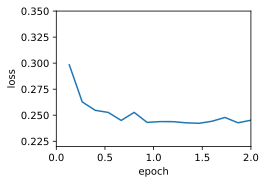

In [0]:
# função para treinar
def train_gluon_ch10(data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.05})
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
  
data_iter, _ = get_data_ch10(10)
train_gluon_ch10(data_iter);

## Momentum

Suponha a seguinte situação: a inclinação da função objetivo tem um valor absoluto maior na direção de uma das váriáveis independentes (ou seja, no nosso caso, na direção de alguma dimensão que determina o peso da rede $W$).
Neste caso, dada a taxa de aprendizado, um GD ou SGD fará com que a variável independente se mova mais rapidamente em uma só direção, ou seja, que aprenda mais rapidamente os melhores valores para os pesos delimitados por essa dimensão.
Portanto, precisamos de uma pequena taxa de aprendizado para impedir que a variável independente ultrapasse a solução ideal para a função objetiva nesta direção.
No entanto, isso fará com que a variável independente se mova mais lentamente em direção à solução ideal nas outras direções (para os outros pesos).
Com uma a taxa de aprendizado um pouco maior, a variável independente irá continuamente ultrapassar a solução ótima na direção da qual se move mais rapidamente e gradualmente divergir.

O método momentum foi proposto para resolver esse problema.
Tecnicamente, suponha uma variável independente $\mathbf{x}_t$ e a taxa de aprendizagem $\eta_t$, ambas no tempo $t$.
No tempo$0$, o momento cria a variável velocidade $\mathbf{v}_0$ e a inicializa com zero.
No intervalo de tempo $t>0$, o algoritmo de momentum modifica o processo de convergência da seguinte forma:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \gamma \mathbf{v}_{t-1} + \eta_t \mathbf{g}_t \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \mathbf{v}_t
\end{aligned}
$$
, onde $\gamma$ ($0 \leq \gamma <1$) é o hiper-parâmetro chamando momentum. Quando $\gamma = 0$, momentum é equivalente a um SGD em mini-*batch*.



### A variável $\mathbf{v_t}$

Para entender o método momentum, podemos expandir a variável velocidade ao longo do tempo:

$$
\begin{aligned}
\mathbf{v}_t &= \eta_t \mathbf{g}_t + \gamma \mathbf{v}_{t-1}, \\
             &= \eta_t \mathbf{g}_t + \gamma \eta_{t-1} \mathbf{g}_{t-1} + \gamma\mathbf{v}_{t-1}, \\
             &\ldots\\
             &= \eta_t \mathbf{g}_t + \gamma \eta_{t-1} \mathbf{g}_{t-1} + \ldots +  \gamma\eta_1\mathbf g_1. \\
\end{aligned}
$$

Como podemos ver, $\mathbf v_t$ é uma soma ponderada sobre todos os gradientes do passado multiplicados pela taxa de aprendizagem correspondente.

Um pequeno $\gamma$ permitirá que a variável de velocidade se concentre em gradientes mais recentes, enquanto um valor maior de $\gamma$ fará com que gradientes antigos tenham maior influência na varíavel $\mathbf{v}$.
Comparado com o GD, o momentum fará com que as atualizações de peso sejam mais consistentes ao longo do tempo.


### Implementação

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o SGD com momentum.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando SGD com momentum ($\eta=0.004$ e $\gamma=0.9$).

loss: 0.245, 0.030 sec/epoch


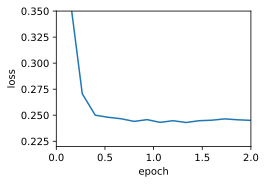

In [0]:
def train_gluon_ch10(data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.004, 'momentum': 0.9})
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))

data_iter, _ = get_data_ch10(10)
train_gluon_ch10(data_iter)

## RMSProp

Nos algoritmos de otimização anteriormente, cada elemento da função objetivo usa a mesma taxa de aprendizado no mesmo intervalo de tempo.
Por exemplo, se assumirmos que a variável independente é vetores bidimensional $[x_1, x_2]^\top$, cada elemento no vetor usa a mesma taxa de aprendizado no processo de otimização.
No caso do GD, por exemplo, a taxa de aprendizado $\eta$ é usada na otimização de $x_1$ e $x_2$:

$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

Anteriormente, vimos que, quando há uma grande diferença entre os valores de gradiente de $x_1$ e $x_2$, uma taxa de aprendizagem pequena deve ser selecionada para que a otimização não diverge a favor da variável com maior gradientes.
Porém, isso faz com o processo de aprendizado seja lento, principalmente para a variável com gradientes menos intensos.
Nesta seção, vamos introduzir RMSProp, um algoritmo que ajusta a taxa de aprendizagem de acordo com o valor do gradiente da variável para eliminar problemas causados quando uma taxa de aprendizado é usada.

### O Algoritmo

O algoritmo usa uma variável acumulativa $\boldsymbol{s}_t$ obtida diretamente dos gradiente $\boldsymbol{g}_t$.
No passo de tempo 0, RMSProp inicializa cada elemento em $\boldsymbol{s}_0$ como 0.
No passo de tempo $t$, a variável $\boldsymbol{s}_t$ é atualizada da seguinte forma:

$$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t \odot \mathbf{g}_t. $$
, onde $\gamma$ ($0 \leq \gamma < 1$) é uma varíavel que determina o quanto os gradientes atuais terão influencia da iteração atual.

Aqui, $\odot$ é o símbolo da multiplicação por elemento.
Em seguida, usamos $\boldsymbol{s}$ para reajustar a taxa de aprendizado $\eta$ de cada elemento:

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t, $$

Aqui, $\eta$ é a taxa de aprendizado, enquanto $\epsilon$ é uma constante pequena (como $10^{- 6}$) adicionada para manter a estabilidade numérica.
As operações de raiz quadrada, divisão e multiplicação são todas operações de elementos (*elementwise*).
Cada elemento na variável independente da função objetivo terá sua própria taxa de aprendizado após as operações por elementos.


### Implementação

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o RMSProp.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando Adagrad ($\eta=0.01$ e $\gamma=0.9$).

loss: 0.245, 0.068 sec/epoch


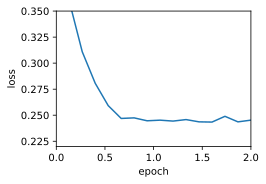

In [3]:
# função para treinar
def train_gluon_ch10(data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(net.collect_params(), 'rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9})
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))

data_iter, _ = get_data_ch10(10)
train_gluon_ch10(data_iter)

## Adam

Adam usa duas variáveis auxilias $\boldsymbol{v}_t$ e $\boldsymbol{s}_t$,  ambas inicializados em 0 no tempo 0.
Dado um hiper-parâmetro $0\leq \beta_1 < 1$ (o autor do algoritmo sugere um valor de 0.9), a variável de momentum $\boldsymbol{v}_t$ no passo de tempo $t$ é atualizada da seguinte forma:

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

Assim como no RMSProp, dado o hiper-parâmetro $0 \leq \beta_2 < 1$ (o autor do algoritmo sugere um valor de 0,999), a variável $\boldsymbol{s}_t$ é atualizada da seguinte forma:

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

Uma normalização é então realiada pelo algoritmo Adam:

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$

Em seguida, o algoritmo Adam usará as variáveis normalizadas para reajustar a taxa de aprendizado:

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$
, one $\eta $ é a taxa de aprendizado, e $\epsilon$ é uma constante adicionada para manter a estabilidade numérica.

Assim como para Adagrad, RMSProp, e Adadelta, cada elemento na variável independente da função objetivo tem sua própria taxa de aprendizado.
Finalmente, usamos $\boldsymbol{g}_t'$ para atualizar e convergir o modelo:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$


### Implementação

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o Adam.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando Adagrad ($\eta=0.01$).

loss: 0.246, 0.032 sec/epoch


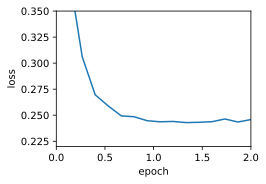

In [0]:
# função para treinar
def train_gluon_ch10(data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.01})
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))

data_iter, _ = get_data_ch10(10)
train_gluon_ch10(data_iter)

## Comparação

<p align="center">
  <img src="https://i.stack.imgur.com/qAx2i.gif">
</p>

<p align="center">
  <img src="https://i.stack.imgur.com/1obtV.gif">
</p>

Valores são as taxas de aprendizado (*learning rate*) ou equivalentes.

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1SK7oK1M07zjOAL_CBvjGwOaRDHnsfBTD">
</p>

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=109Sb0E98Ez61oB-W3DAcwOBXmqBRVEPT">
</p>
